In [354]:
%pip install tensorflow numpy matplotlib pandas scikit-learn seaborn


[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [802]:
import os
os.environ["KERAS_BACKEND"] = "tensorflow"

import numpy as np
import matplotlib.pyplot as plt
import keras
from keras import Model, Input, layers, losses, activations, ops, callbacks
from sklearn.model_selection import train_test_split
import pandas as pd
import json
import glob


In [803]:
def smooth(data, alpha=0.5):
    return pd.Series(data).ewm(alpha=alpha).mean().to_numpy()

In [804]:
def plot_hr(data):
    plt.figure(figsize=(18, 4))
    plt.plot(data)
    plt.ylim(0,200)
    plt.show()

In [805]:
def zero_constant_regions(data, window=10, threshold=0.01):
    data = np.asarray(data)
    result = np.copy(data)
    
    for i in range(len(data) - window + 1):
        segment = data[i:i+window]
        std = np.std(segment)
        
        if std < threshold:
            result[i:i+window] = 0  # Flatten to zero

    return result

In [905]:
raw = []

for json_file in glob.glob('rawhr/*.json'):
    with open(json_file, 'r') as file:
        data = json.load(file)
        hr = list(map(lambda x: x[1], data['heartRateValues']))

        if len(hr) != 720:
            print(json_file)
        
        raw.append(hr)

hr_data = []
target_hr_data = []

for i in range(10):
    
    d0 = list(map(lambda x: smooth(x, 1.0-(0.05*i)), raw))
    d1 = list(map(lambda x: smooth(x, 1.0-(0.05*(i+1))), raw))
    
    hr_data = hr_data + d0
    target_hr_data = target_hr_data + d1

for i in range(10):
    
    d0 = list(map(lambda x: smooth(x, 0.95-(0.05*i)), raw))
    d1 = list(map(lambda x: smooth(x, 0.95-(0.05*(i+1))), raw))
    
    hr_data = hr_data + d0
    target_hr_data = target_hr_data + d1
    

hr_data = np.array(hr_data)
target_hr_data = np.array(target_hr_data)

#
# base RHR 52 
# RHR=[52, 62, 72, 82]
#
hr_data = np.concatenate([hr_data, hr_data+10, hr_data+20, hr_data+30])
target_hr_data = np.concatenate([target_hr_data, target_hr_data+10, target_hr_data+20, target_hr_data+30])

hr_data = np.concatenate([hr_data, hr_data, hr_data])
target_hr_data = np.concatenate([target_hr_data, target_hr_data, target_hr_data])

print(hr_data.shape)

(19200, 720)


In [906]:
x_train = hr_data.astype('float32') / 250.0
target_train = target_hr_data.astype('float32') / 250.0

x_train_normal, x_val_normal, target_train, target_val = train_test_split(x_train, target_train, test_size=0.25, random_state=42, shuffle=True)

print(x_train.shape, x_train_normal.shape, x_val_normal.shape, target_train.shape, target_val.shape)

(19200, 720) (14400, 720) (4800, 720) (14400, 720) (4800, 720)


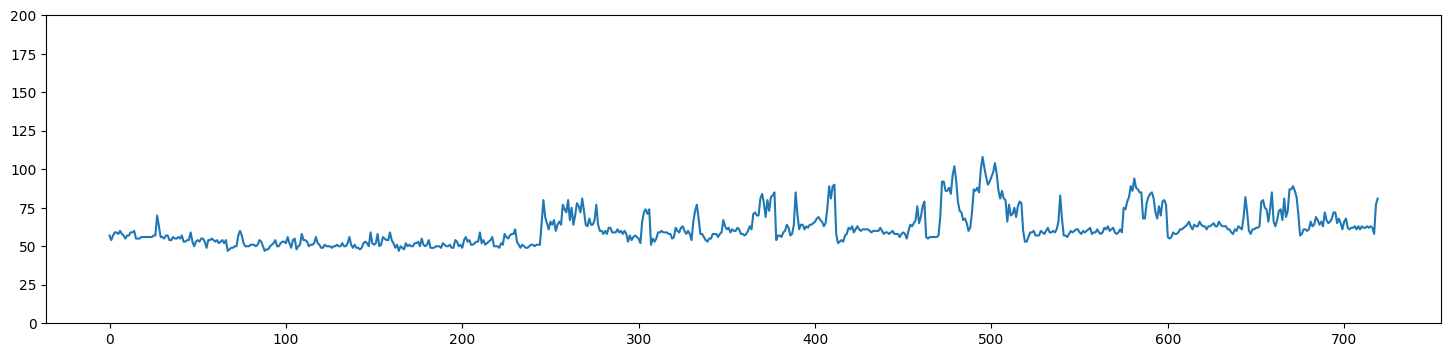

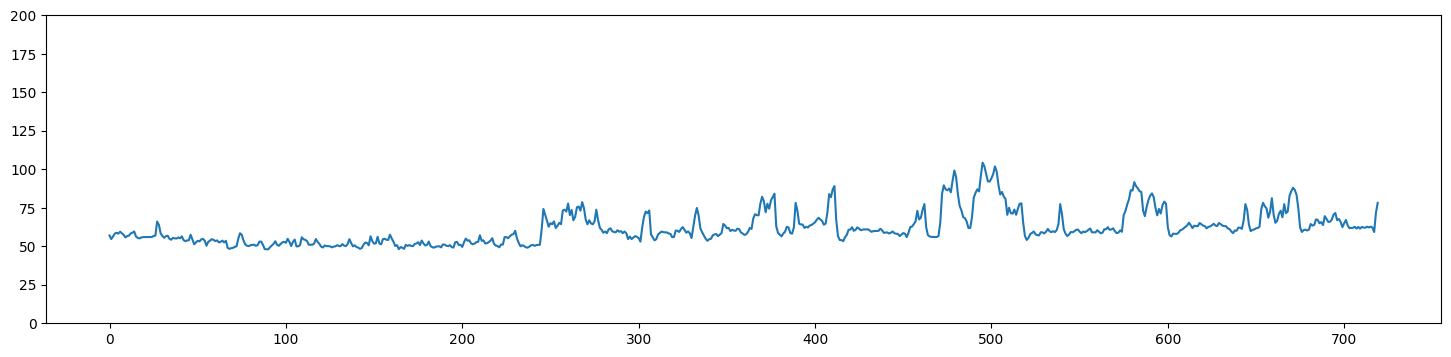

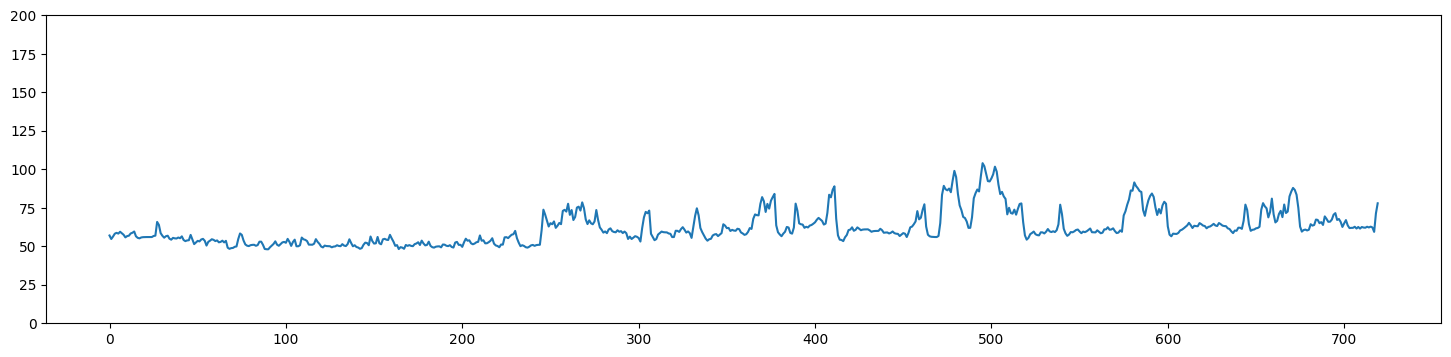

In [907]:
d_data = hr_data[6]

plot_hr(d_data)
plot_hr(smooth(d_data,0.7))
plot_hr(smooth(d_data,0.68))


In [908]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.seed_generator = keras.random.SeedGenerator(1337)

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = ops.shape(z_mean)[0]
        dim = ops.shape(z_mean)[1]
        epsilon = keras.random.normal(shape=(batch, dim), seed=self.seed_generator)
        return z_mean + ops.exp(0.5 * z_log_var) * epsilon

In [909]:
Dense = layers.Dense

latent_dim = 3
input_dim = 720

input_encoder = Input(shape=(input_dim,))

# Encoder
x = Dense(720,"leaky_relu")(input_encoder)
x = Dense(360,"leaky_relu" )(x)
x = Dense(180,"leaky_relu")(x)
x = Dense(90,"leaky_relu")(x)
x = Dense(24,"leaky_relu")(x)

z_mu = Dense(latent_dim, name='latent_mu')(x)
z_log_var = Dense(latent_dim, name='latent_logvar')(x)
z = Sampling()([z_mu, z_log_var])

encoder = Model(inputs=input_encoder, outputs=[z_mu, z_log_var, z], name='encoder')
encoder.summary()

#decoder
input_decoder = Input(shape=(latent_dim,), name='decoder_input')
x = Dense(24,"leaky_relu")(input_decoder)
x = Dense(90,"leaky_relu")(x)
x = Dense(180,"leaky_relu")(x)
x = Dense(360,"leaky_relu")(x)
x = Dense(720,"leaky_relu")(x)
dec = Dense(input_dim, activation='sigmoid')(x)    
decoder = Model(inputs=input_decoder, outputs=dec, name='decoder_CNN')
decoder.summary()

vae_outputs = decoder(encoder(input_encoder)[2])
vae = Model(input_encoder, vae_outputs, name='vae')
vae.summary()

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_95      │ (None, 720)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_903 (Dense)   │ (None, 720)       │    519,120 │ input_layer_95[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_904 (Dense)   │ (None, 360)       │    259,560 │ dense_903[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_905 (Dense)   │ (None, 180)       │     64,980 │ dense_904[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_906 (Dense)   │ (None, 90)        │     16,290 │ dense_905[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_907 (Dense)   │ (None, 24)        │      2,184 │ dense_906[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ latent_mu (Dense)   │ (None, 3)         │         75 │ dense_907[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ latent_logvar       │ (None, 3)         │         75 │ dense_907[0][0]   │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sampling_95         │ (None, 3)         │          0 │ latent_mu[0][0],  │
│ (Sampling)          │                   │            │ latent_logvar[0]… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 862,284 (3.29 MB)

 Trainable params: 862,284 (3.29 MB)

 Non-trainable params: 0 (0.00 B)

Model: "decoder_CNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ decoder_input (InputLayer)      │ (None, 3)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_908 (Dense)               │ (None, 24)             │            96 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_909 (Dense)               │ (None, 90)             │         2,250 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_910 (Dense)               │ (None, 180)            │        16,380 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_911 (Dense)               │ (None, 360)            │        65,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_912 (Dense)               │ (None, 720)            │       259,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_913 (Dense)               │ (None, 720)            │       519,120 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 862,926 (3.29 MB)

 Trainable params: 862,926 (3.29 MB)

 Non-trainable params: 0 (0.00 B)

Model: "vae"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_95 (InputLayer)     │ (None, 720)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder (Functional)            │ [(None, 3), (None, 3), │       862,284 │
│                                 │ (None, 3)]             │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_CNN (Functional)        │ (None, 720)            │       862,926 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,725,210 (6.58 MB)

 Trainable params: 1,725,210 (6.58 MB)

 Non-trainable params: 0 (0.00 B)

In [910]:
# Compile the model
vae.compile(optimizer='adam', loss=losses.MeanSquaredError())

In [911]:
early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = callbacks.ReduceLROnPlateau(factor=0.5, patience=5, min_lr=1e-6)


# Train the VAE
history = vae.fit(x_train_normal, target_train,
                          epochs=40,
                          batch_size=32,
                          shuffle=True,
                          validation_data=(x_val_normal, target_val),
                          callbacks=[early_stopping, reduce_lr])

Epoch 1/40
450/450 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 0.0063 - val_loss: 0.0024 - learning_rate: 0.0010
Epoch 2/40
450/450 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0024 - val_loss: 0.0025 - learning_rate: 0.0010
Epoch 3/40
450/450 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0024 - val_loss: 0.0018 - learning_rate: 0.0010
Epoch 4/40
450/450 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0018 - val_loss: 0.0018 - learning_rate: 0.0010
Epoch 5/40
450/450 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0018 - val_loss: 0.0018 - learning_rate: 0.0010
Epoch 6/40
450/450 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0016 - val_loss: 0.0015 - learning_rate: 0.0010
Epoch 7/40
450/450 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0014 - val_loss: 0.0014 - learning_rate: 0.0010
Epoch 8/40
450/450 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0013 - val_loss: 0.0012 - learning_rate: 0.0010
Epoch 9/40
450/450 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0012 - val_loss: 9.7758e-04 - learning_rate: 0.0010
Epoch 

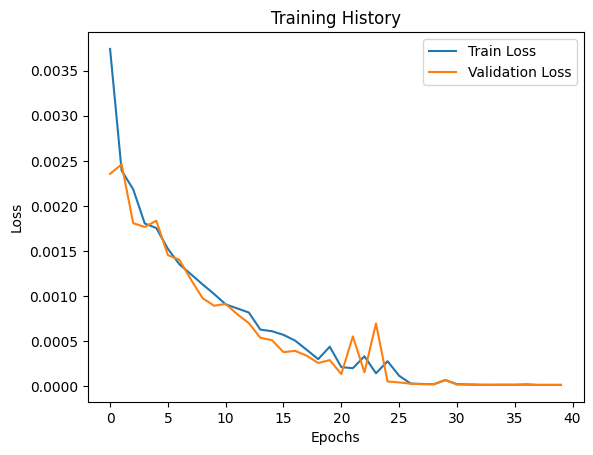

In [912]:
# Plot the training history
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training History')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

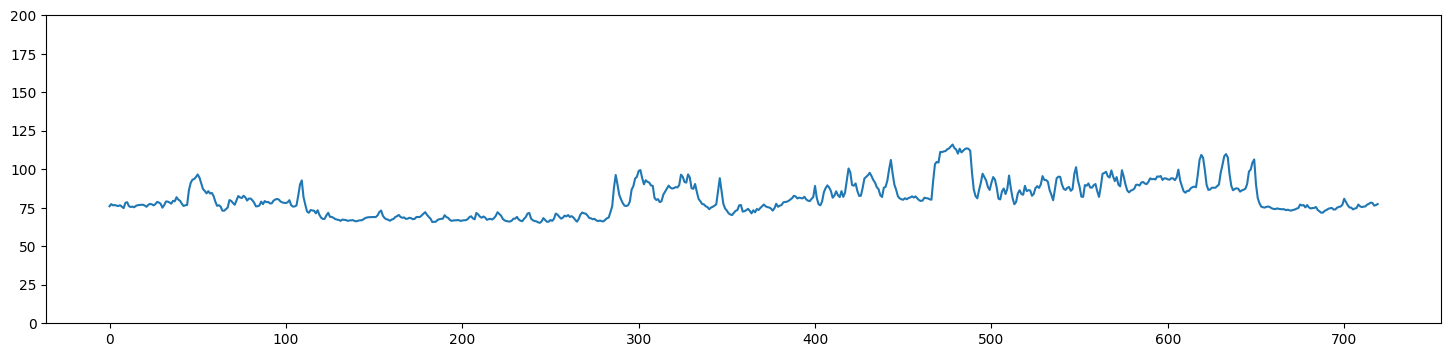

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


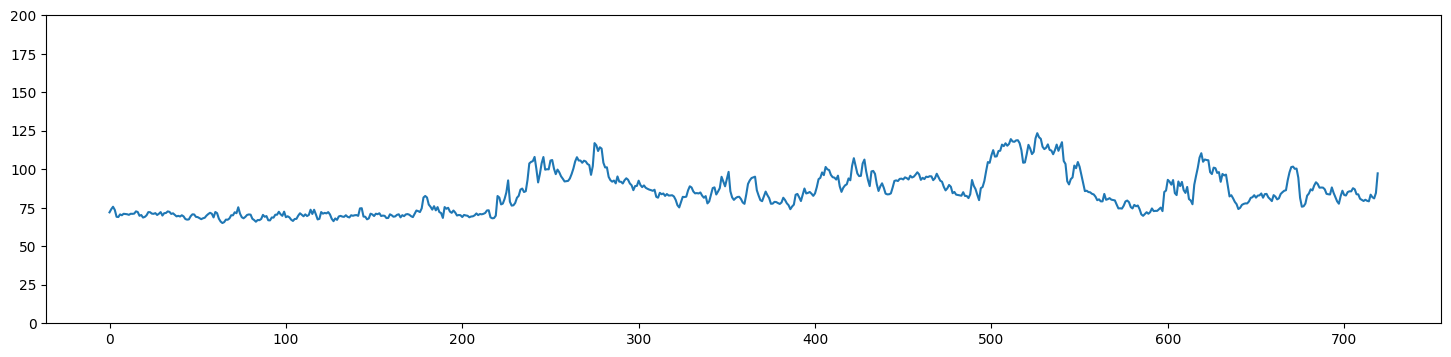

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


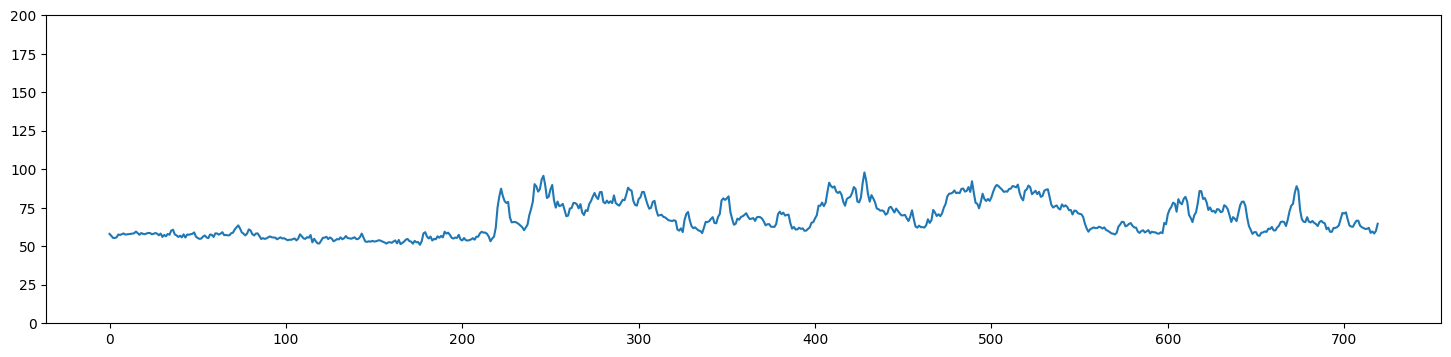

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


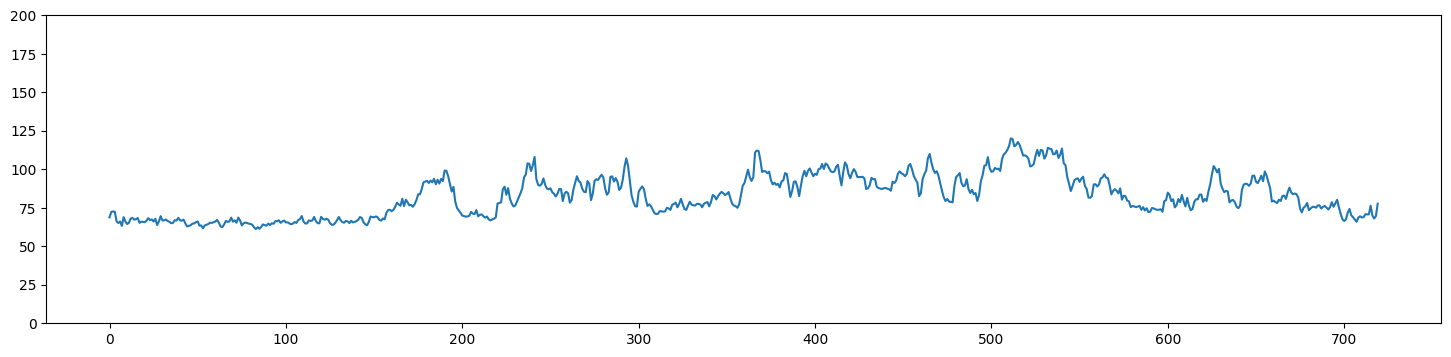

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


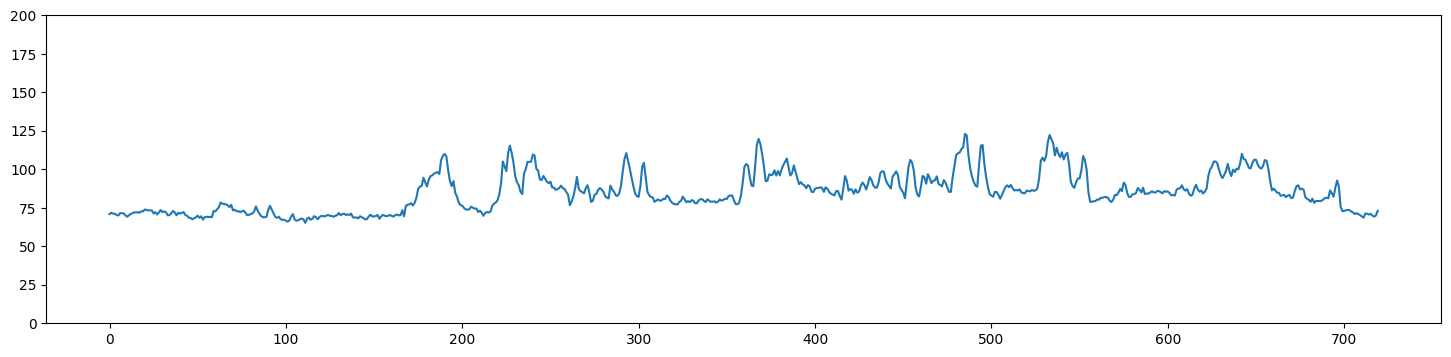

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


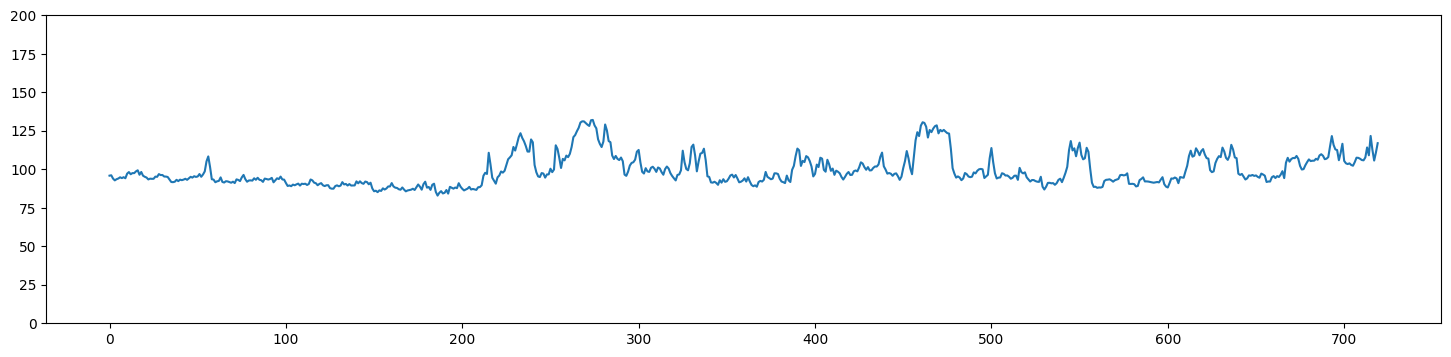

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


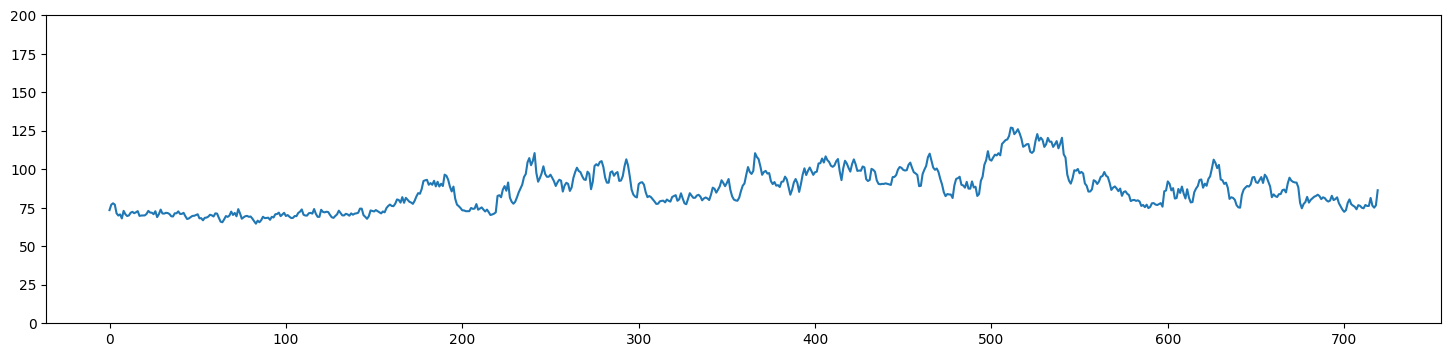

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


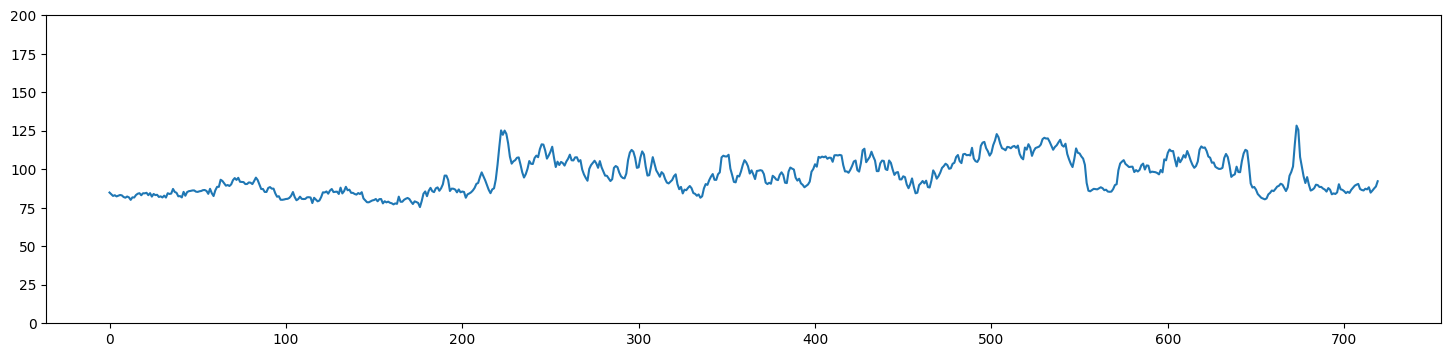

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


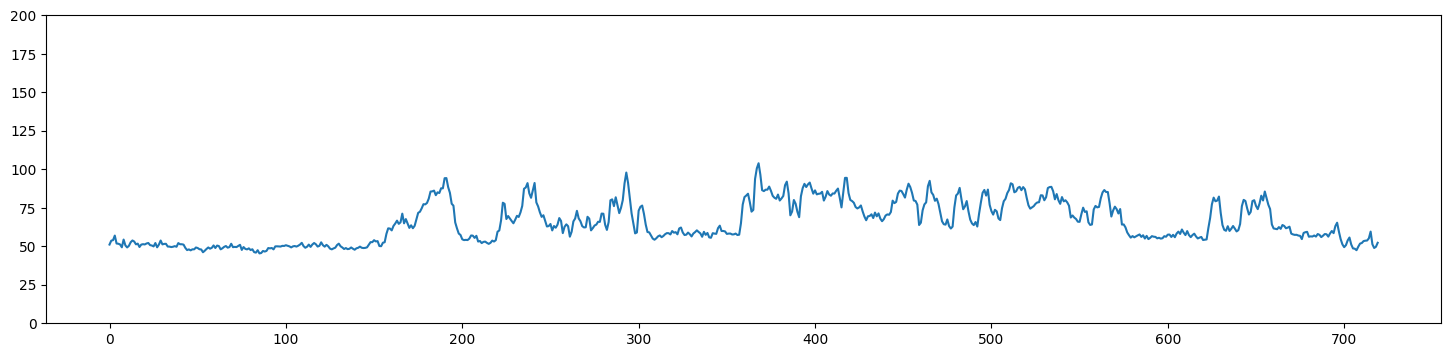

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


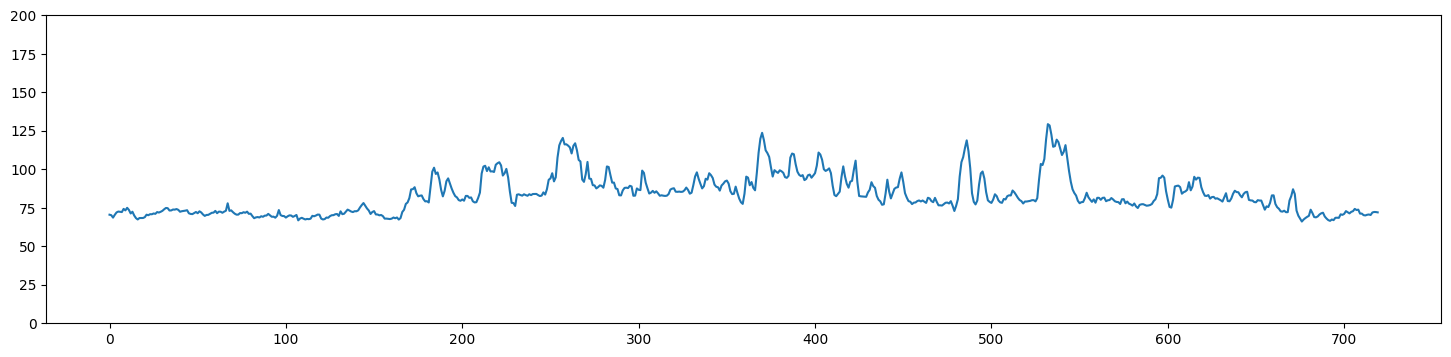

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


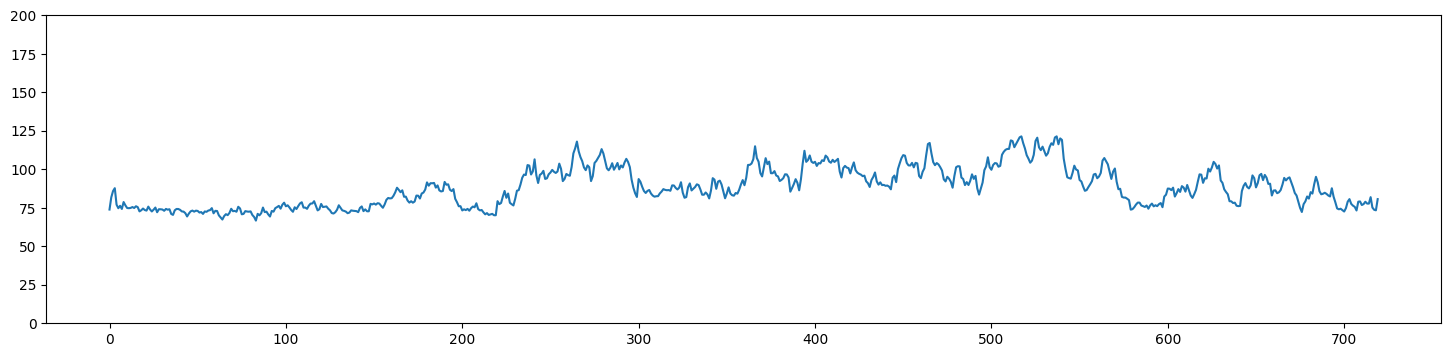

In [915]:
#x_out_val = vae.predict(x_val_normal)

plot_hr(x_val_normal[1]*250)
#plot_hr(x_out_val[1]*250)

for i in range(10):
    newrandow = np.random.normal(loc=x_train_normal[i].mean(), scale=x_train_normal[i].std(),size=(1, 720))
    newrandow = vae.predict(newrandow)
    plot_hr(newrandow[0]*250)

In [917]:
encoder.save("models/encoder.keras")
decoder.save("models/decoder.keras")
vae.save("models/vae.keras")